In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from datetime import datetime

In [2]:
#client = MongoClient('') - connect to Mongo
#db = client['Amazone'] - choose Amazone DB

In [23]:
#convert date to the right format
target_date = datetime.strptime('2023-12-06', '%Y-%m-%d')

In [24]:
#pipeline construction
pipeline_other = [
    {"$unwind": "$order_items"},
    {
        "$lookup": {
            "from": "OtherProducts",
            "localField": "order_items.product_id",
            "foreignField": "_id",
            "as": "otherProduct"
        }
    },
    {"$unwind": "$otherProduct"},
    {
        "$match": {
            "otherProduct.type": {"$in": ["book", "CD", "home appliance", "mobile phone"]}
        }
    },
    {
        "$group": {
            "_id": "$otherProduct.type",
            "totalSales": {"$sum": {"$multiply": ["$order_items.quantity", "$otherProduct.standard_price"]}},
            "totalQuantity": {"$sum": "$order_items.quantity"}
        }
    },
    {
        "$lookup": {
            "from": "OtherProducts",
            "localField": "_id",
            "foreignField": "type",
            "as": "inventoryInfo"
        }
    },
    {"$unwind": "$inventoryInfo"},
    {"$unwind": "$inventoryInfo.daily_inventory_level"},
    {
        "$match": {
            "inventoryInfo.daily_inventory_level.date": target_date
        }
    },
    {
        "$project": {
            "_id": 1,
            "totalSales": 1,
            "totalQuantity": 1,
            "inventoryInfo": {
                "name": 1,
                "inventory_quantity": "$inventoryInfo.daily_inventory_level.inventory_quantity"
            }
        }
    }
]

In [25]:
#aggregation
result = list(db.PastOrders.aggregate(pipeline_other))

In [26]:
#convert result to pandas df
df = pd.DataFrame(result)

In [27]:
print(df)

               _id  totalSales  totalQuantity  \
0   home appliance     9561.47             26   
1   home appliance     9561.47             26   
2   home appliance     9561.47             26   
3   home appliance     9561.47             26   
4   home appliance     9561.47             26   
5   home appliance     9561.47             26   
6   home appliance     9561.47             26   
7   home appliance     9561.47             26   
8   home appliance     9561.47             26   
9   home appliance     9561.47             26   
10            book      345.50             24   
11            book      345.50             24   
12            book      345.50             24   
13            book      345.50             24   
14            book      345.50             24   
15            book      345.50             24   
16            book      345.50             24   
17            book      345.50             24   
18            book      345.50             24   
19            book  

In [28]:
pastel_purple = (200/255, 160/255, 255/255)
pastel_yellow = (255/255, 253/255, 182/255)
pastel_green =  (173/255, 255/255, 182/255) 
pastel_blue = (173/255, 216/255, 230/255)

In [29]:
colours2= [pastel_green, pastel_yellow, pastel_blue, pastel_purple]

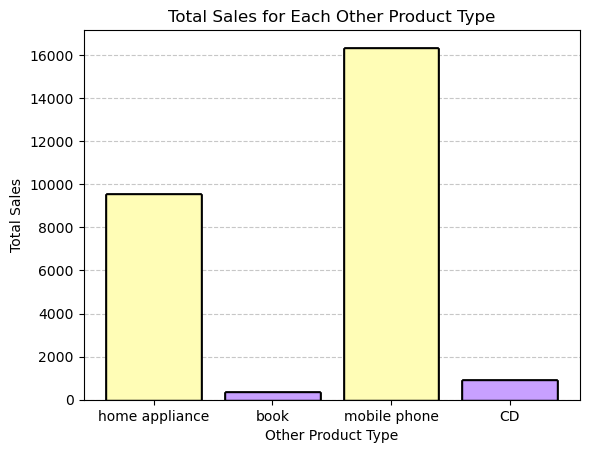

In [30]:
#plot sales for each other product type
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.bar(df['_id'], df['totalSales'], color=colours2, zorder=2, edgecolor='black')
plt.xlabel('Other Product Type')
plt.ylabel('Total Sales')
plt.title('Total Sales for Each Other Product Type')
plt.savefig('other_sales_plot.png')
plt.show()

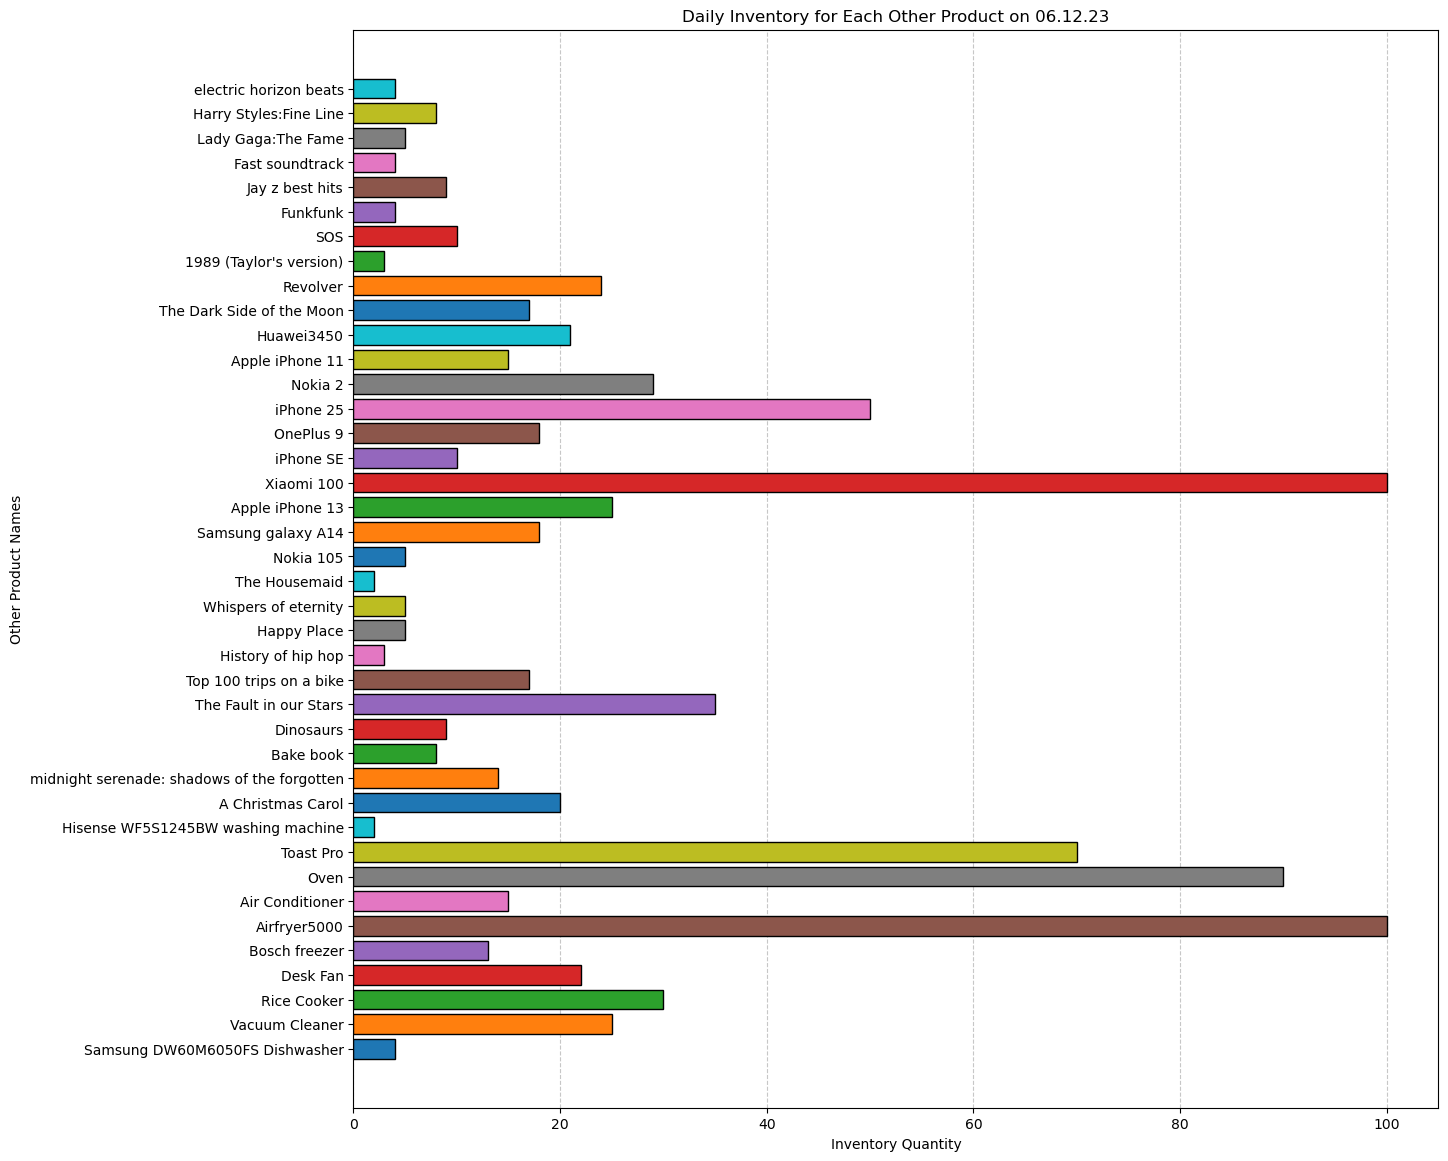

In [18]:
#plot daily inventory for 06.12 for other products
plt.figure(figsize=(14, 14))
for index, row in df.iterrows():
    plt.barh(row['inventoryInfo']['name'], row['inventoryInfo']['inventory_quantity'], zorder=2, edgecolor='black')

plt.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=1)
plt.xlabel('Inventory Quantity')
plt.ylabel('Other Product Names')
plt.title('Daily Inventory for Each Other Product on 06.12.23')
plt.savefig('other_daily_inventory.png')
plt.show()